In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
from google.colab.data_table import DataTable
DataTable.max_columns = 60

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/Shared drives/EE660_Proj/Submissions")
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import random
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from matplotlib import pyplot
import csv
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix #install module to plot confusion matrix
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

#100% Labelled Data - Supervised Learning

Loading Training Data

In [ ]:
valid_rows = []
with open('data/crx-10-1tra.dat') as f:
  spamreader = csv.reader(f, delimiter=' ')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
          
      valid_rows.append(row)
df_trainsl = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])
df_trainsl

In [ ]:
df_trainsl.isnull().sum()

In [ ]:
valid_rows = []
with open('data/crx-10-1tst.dat') as f:
  spamreader = csv.reader(f, delimiter=' ')
  for row in spamreader:
    if not(re.search('^@', row[0])):
      row = [re.sub(",","", i) for i in row]
      for i in range(len(row)):
        if row[i] == '<null>':
          row[i] = None
      valid_rows.append(row)
df_testsl = pd.DataFrame(valid_rows, columns=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'Class'])
df_testsl

In [ ]:
df_testsl.isnull().sum()

In [ ]:
def label_encode(dataset,labels):
  lb=LabelEncoder()
  for i in labels:
    lb.fit(dataset[i])
    dataset[i]=lb.transform(dataset[i])

labels = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
label_encode(df_trainsl, labels)
label_encode(df_testsl, labels)
df_trainsl

Splitting X and Y from Dataframes

In [ ]:
X_train = df_trainsl.iloc[:,:-1]
y_train = df_trainsl.iloc[:,-1]
X_test = df_testsl.iloc[:,:-1]
y_test = df_testsl.iloc[:,-1]

Trivial System:

In [ ]:
def calculate_prior_probabilities(dataset, label):
  probabs = pd.DataFrame(dataset[label].value_counts())
  sum = probabs.sum(axis=0)
  probabs=(probabs/sum[0]).round(2)
  categories = list(probabs.index)
  weights = list(probabs.iloc[:,0])
  return categories, weights

def calc_metrics_trv(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  macro_f1_score = f1_score(y_true, y_pred, average='macro')
  return accuracy,macro_f1_score

def trivial_system_classifier(categories, weights, testing_dataset):
  y_pred = []

  for i in range(len(testing_dataset)):
    y_pred.extend(random.choices(categories, weights))
  return np.array(y_pred)
  
def final_triv(train_cat, train_weights, data_test):
  y_pred_m1 = []
  acc_temp = []
  macro_list = []
  for i in range(10):
    y_pred_m1 = trivial_system_classifier(train_cat, train_weights, data_test)
    accuracy,macro = calc_metrics_trv(data_test.iloc[:,-1], y_pred_m1)
    acc_temp.append(accuracy)
    macro_list.append(macro)
  avg_acc = sum(acc_temp)/len(acc_temp)
  avg_macro = sum(macro_list)/len(macro_list)
  print("Accuracy:",avg_acc)
  print("Macro f1-score:",avg_macro)

train_categories, train_weights = calculate_prior_probabilities(df_trainsl, "Class")
final_triv(train_categories, train_weights, df_testsl)

Accuracy: 0.48695652173913045
Macro f1-score: 0.47799699576918186


Handling Missing Values

In [ ]:
neigh_list = [i for i in range(2,10)]
n_list = []
max_acc = float('-inf')
for i in neigh_list:
  imputer = KNNImputer(n_neighbors=i)
  X_train = imputer.fit_transform(X_train)
  X_test = imputer.fit_transform(X_test)
  clf = LogisticRegression(random_state=0)
  clf.fit(X_train, y_train)
  y_pred_train = clf.predict(X_train)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best neighbor parameter',n_list[-1])

imputer = KNNImputer(n_neighbors=n_list[-1])
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

Best neighbor parameter 2


In [ ]:
def calc_metrics(y_true, y_pred,model_name):
  print(model_name)
  accuracy = accuracy_score(y_true, y_pred)
  macro_f1_score = f1_score(y_true, y_pred, average='macro')

  print("Accuracy:", accuracy)
  print("Macro f1-score:", macro_f1_score)
  
  #Confusion matrix plot
  print("\n")
  plt.clf()
  fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred), figsize=(8,6), cmap=plt.cm.Reds, colorbar = True)
  plt.xticks(range(2), ['positive', 'negative'])
  plt.yticks(range(2), ['positive', 'negative'])
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix for ' + model_name, fontsize=20)
  plt.show()
  print("\n\n")

Baseline Models:

*   Nearest Means Classifier
*   Logistic Regression


Nearest Means Classifier
Accuracy: 0.6521739130434783
Macro f1-score: 0.5775510204081632




<Figure size 432x288 with 0 Axes>

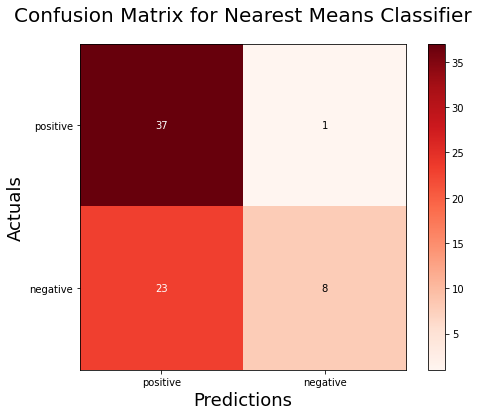

In [ ]:
clf = NearestCentroid()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test, y_pred, 'Nearest Means Classifier')

Logistic Regression
Accuracy: 0.782608695652174
Macro f1-score: 0.780952380952381




<Figure size 432x288 with 0 Axes>

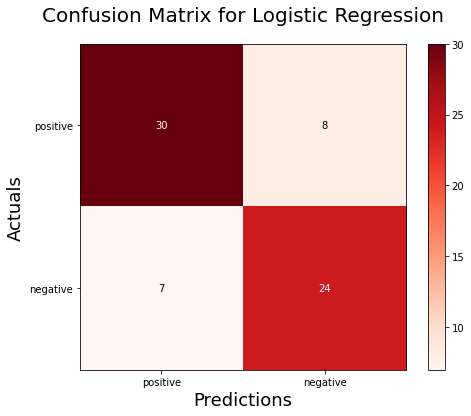

In [ ]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
calc_metrics(y_test,y_pred,'Logistic Regression')

Models without Feature Selection/Engineering Techniques:


Fitting 10 folds for each of 648 candidates, totalling 6480 fits
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Classifier
Accuracy: 0.855072463768116
Macro f1-score: 0.8535653650254669




<Figure size 432x288 with 0 Axes>

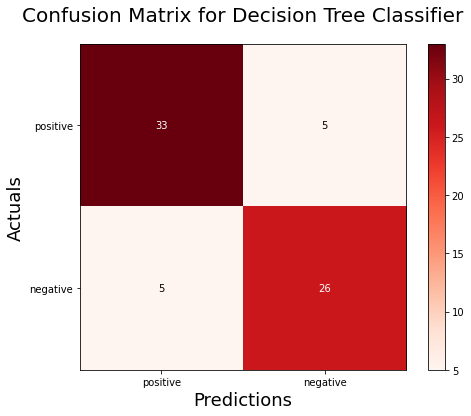

In [ ]:
decision_tree = DecisionTreeClassifier()

param_dict = {
    "criterion" : ['gini','entropy'],
    "max_depth" : range(1,10),
    "min_samples_split": range(1,10),
    "min_samples_leaf": range(1,5)
}

grid = GridSearchCV(decision_tree,
                    param_grid = param_dict,
                    cv = 10,
                    verbose = 1,
                    n_jobs = -1)

grid.fit(X_train, y_train)
best_grid_dt = grid.best_estimator_
y_pred = best_grid_dt.predict(X_test)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Decision Tree Classifier')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'learning_rate': 0.01, 'n_estimators': 10}
Adaboost Classifier
Accuracy: 0.855072463768116
Macro f1-score: 0.8535653650254669




<Figure size 432x288 with 0 Axes>

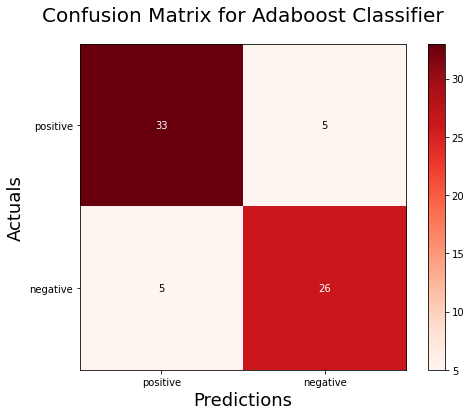

In [ ]:
ada_boost = AdaBoostClassifier(random_state=0)
param_dict = {'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.05,0.1]}

grid = GridSearchCV(ada_boost,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_train,y_train)
best_grid_ada = grid.best_estimator_
y_pred = best_grid_ada.predict(X_test)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Adaboost Classifier')

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
RandomForest Classifier
Accuracy: 0.8985507246376812
Macro f1-score: 0.8963741686333406




<Figure size 432x288 with 0 Axes>

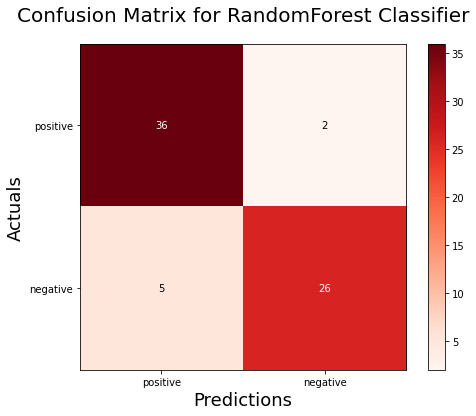

In [ ]:
rfc = RandomForestClassifier(random_state=0)

param_dict = { 
    'n_estimators': [100,200,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6,7],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train,y_train)
best_grid_rfc = grid.best_estimator_
y_pred = best_grid_rfc.predict(X_test)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'RandomForest Classifier')

Comparison with and without Standardization for the distance based models

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
KNeighbors Classifier - Non-Standardized Features
Accuracy: 0.6666666666666666
Macro f1-score: 0.6477247502774695




<Figure size 432x288 with 0 Axes>

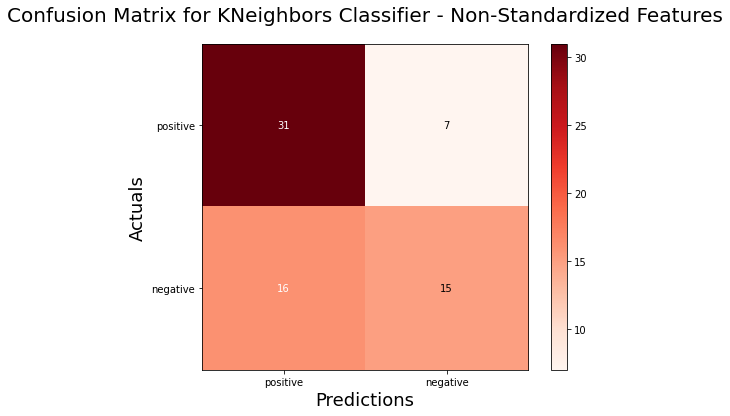

In [ ]:
neigh = KNeighborsClassifier()

param_dict = { 
    'n_neighbors': range(2,10),
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean','manhattan']
}

grid = GridSearchCV(neigh,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train,y_train)
best_grid_knc = grid.best_estimator_
y_pred = best_grid_knc.predict(X_test)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'KNeighbors Classifier - Non-Standardized Features')

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
KNeighbors Classifier
Accuracy: 0.8840579710144928
Macro f1-score: 0.882051282051282




<Figure size 432x288 with 0 Axes>

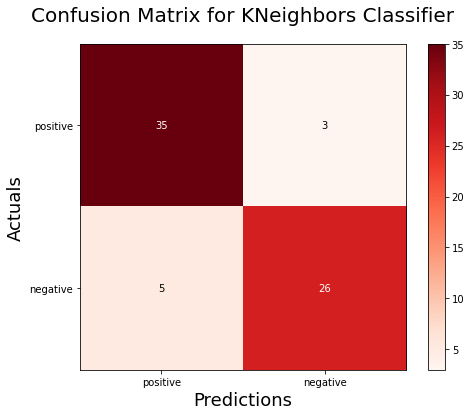

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

neigh = KNeighborsClassifier()

param_dict = { 
    'n_neighbors': range(2,10),
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean','manhattan']
}

grid = GridSearchCV(neigh,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train_sc,y_train)
best_grid_knc = grid.best_estimator_
y_pred = best_grid_knc.predict(X_test_sc)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'KNeighbors Classifier')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
Support Vector Classifier
Accuracy: 0.855072463768116
Macro f1-score: 0.8535653650254669




<Figure size 432x288 with 0 Axes>

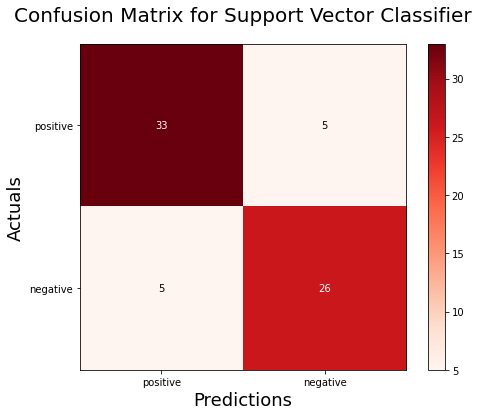

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

svc = SVC()

param_dict = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svc,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train_sc,y_train)
best_grid_svc = grid.best_estimator_
y_pred = best_grid_svc.predict(X_test_sc)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Support Vector Classifier')

Model Performance after Recursive Feature Elimination Technique:



Best n_feature parameter 3
Decision Tree Classifier
Accuracy: 0.7536231884057971
Macro f1-score: 0.7483372666809698




<Figure size 432x288 with 0 Axes>

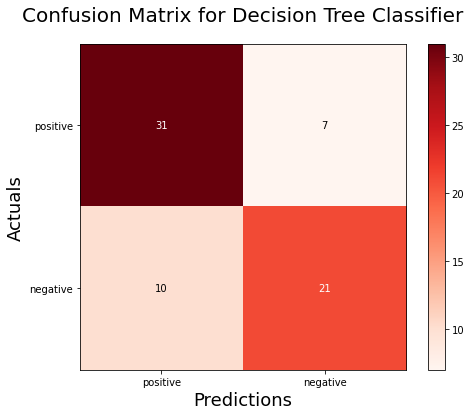

In [ ]:
n_feature_list = [i for i in range(2,14)]
n_feat = []
max_acc = float('-inf')
for i in n_feature_list:

  rfe = RFE(DecisionTreeClassifier(random_state = 0),n_features_to_select=i)
  rfe.fit(X_train,y_train)
  y_pred_train = rfe.predict(X_train)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_feat.append(i)
print('Best n_feature parameter',n_feat[-1])

rfe = RFE(DecisionTreeClassifier(random_state = 0),n_features_to_select=n_feat[-1])
rfe.fit(X_train,y_train)
y_pred = rfe.predict(X_test)
calc_metrics(y_test,y_pred,'Decision Tree Classifier')

Best n_feature parameter 8
Adaboost Classifier
Accuracy: 0.7971014492753623
Macro f1-score: 0.7918103448275862




<Figure size 432x288 with 0 Axes>

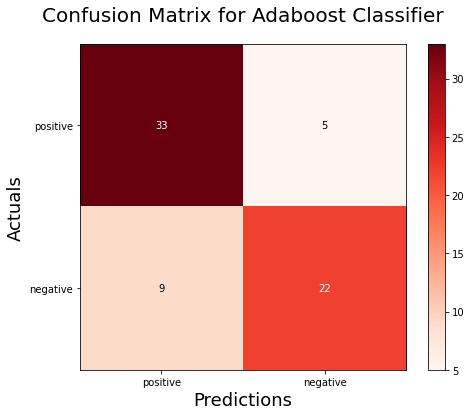

In [ ]:
n_feature_list = [i for i in range(2,14)]
n_feat = []
max_acc = float('-inf')
for i in n_feature_list:

  rfe = RFE(AdaBoostClassifier(),n_features_to_select=i)
  rfe.fit(X_train,y_train)
  y_pred_train = rfe.predict(X_train)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_feat.append(i)
print('Best n_feature parameter',n_feat[-1])

rfe = RFE(AdaBoostClassifier(),n_features_to_select=n_feat[-1])
rfe.fit(X_train,y_train)
y_pred = rfe.predict(X_test)
calc_metrics(y_test,y_pred,'Adaboost Classifier')

Best n_feature parameter 3
Random Forest Classifier
Accuracy: 0.782608695652174
Macro f1-score: 0.7758284600389863




<Figure size 432x288 with 0 Axes>

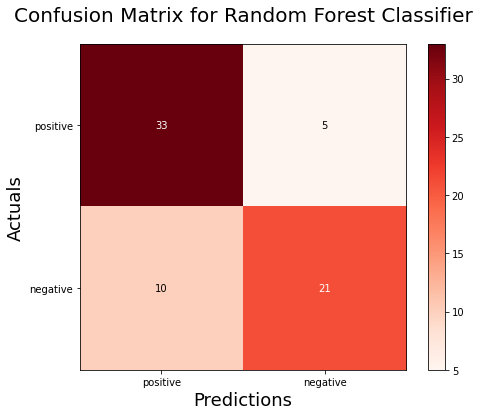

In [ ]:
n_feature_list = [i for i in range(2,14)]
n_feat = []
max_acc = float('-inf')
for i in n_feature_list:

  rfe = RFE(RandomForestClassifier(random_state = 0),n_features_to_select=i)
  rfe.fit(X_train,y_train)
  y_pred_train = rfe.predict(X_train)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_feat.append(i)
print('Best n_feature parameter',n_feat[-1])

rfe = RFE(RandomForestClassifier(random_state = 0),n_features_to_select=n_feat[-1])
rfe.fit(X_train,y_train)
y_pred = rfe.predict(X_test)
calc_metrics(y_test,y_pred,'Random Forest Classifier')

Model Performance after Chi2 Feature Selection Technique:

In [ ]:
def chi2_classmodel(X_train,y_train,X_test,y_test,model,model_name):
  param_list = [i for i in range(2,14)]
  n_feat = []
  max_acc = float('-inf')
  for i in param_list:
    clf = SelectKBest(score_func=chi2, k=i)
    clf.fit(X_train, y_train)
    X_train_new = clf.fit_transform(X_train, y_train)
    classifier = model
    classifier.fit(X_train_new, y_train)
    y_pred_train = classifier.predict(X_train_new)

    acc = accuracy_score(y_train,y_pred_train)
    if acc > max_acc:
      max_acc = acc
      n_feat.append(i)
  print('Best K parameter',n_feat[-1])
  
  clf = SelectKBest(score_func=chi2, k=n_feat[-1])
  clf.fit(X_train, y_train)
  X_train_new = clf.fit_transform(X_train, y_train)
  X_test_new = clf.transform(X_test)
  
  classifier = model
  classifier.fit(X_train_new, y_train)

  y_pred = classifier.predict(X_test_new)

  calc_metrics(y_test, y_pred, model_name)

Best K parameter 4
Decision Tree Classifier
Accuracy: 0.7246376811594203
Macro f1-score: 0.7160493827160493




<Figure size 432x288 with 0 Axes>

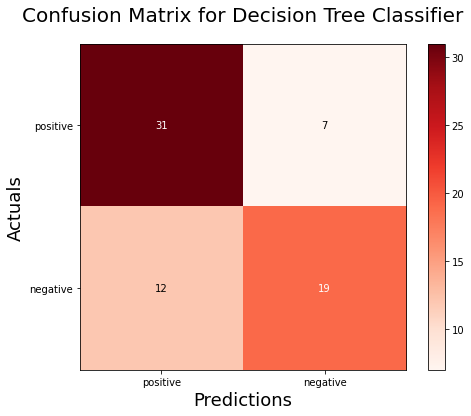

In [ ]:
chi2_classmodel(X_train,y_train,X_test,y_test,DecisionTreeClassifier(random_state = 0),'Decision Tree Classifier')

Best K parameter 9
Adaboost Classifier
Accuracy: 0.7971014492753623
Macro f1-score: 0.7918103448275862




<Figure size 432x288 with 0 Axes>

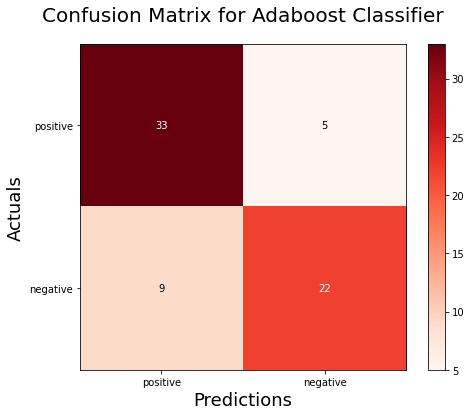

In [ ]:
chi2_classmodel(X_train,y_train,X_test,y_test,AdaBoostClassifier(random_state=0),'Adaboost Classifier')

Best K parameter 4
Random Forest Classifier
Accuracy: 0.7101449275362319
Macro f1-score: 0.6914132379248658




<Figure size 432x288 with 0 Axes>

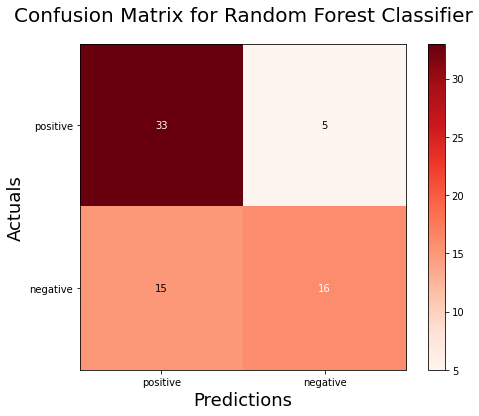

In [ ]:
chi2_classmodel(X_train,y_train,X_test,y_test,RandomForestClassifier(random_state=0),'Random Forest Classifier')

Best K parameter 3
K Nearest Neighbors Classifier
Accuracy: 0.6521739130434783
Macro f1-score: 0.6349206349206349




<Figure size 432x288 with 0 Axes>

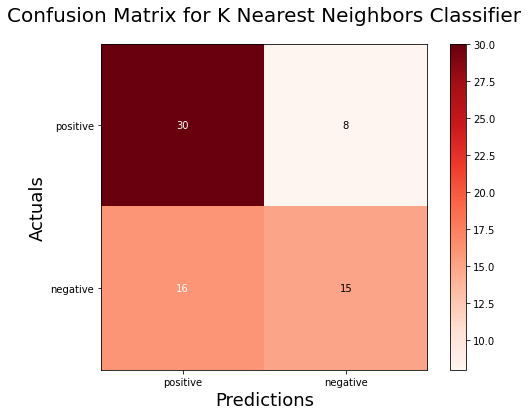

In [ ]:
chi2_classmodel(X_train,y_train,X_test,y_test,KNeighborsClassifier(),'K Nearest Neighbors Classifier')

Best K parameter 4
Support Vector Classifier
Accuracy: 0.6521739130434783
Macro f1-score: 0.5775510204081632




<Figure size 432x288 with 0 Axes>

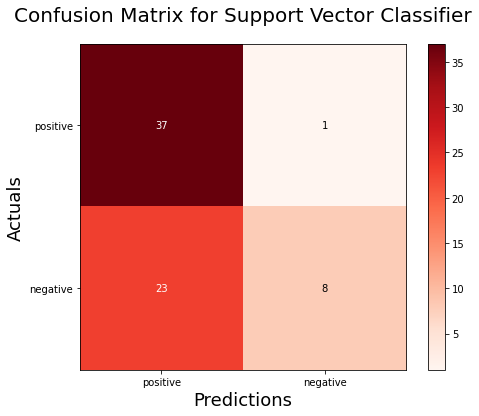

In [ ]:
chi2_classmodel(X_train,y_train,X_test,y_test,SVC(),'Support Vector Classifier')

Dimensionality Reduction

Model performance after PCA:

Best component parameter 9
Logistic Regression
Accuracy: 0.8405797101449275
Macro f1-score: 0.8371594078523921




<Figure size 432x288 with 0 Axes>

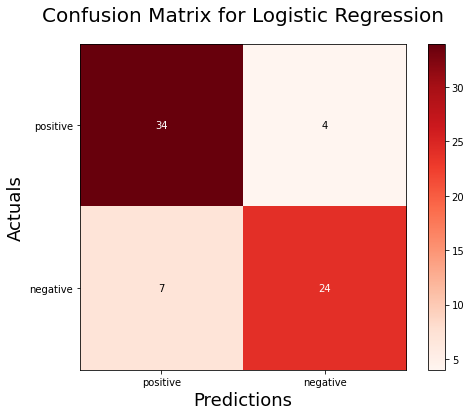

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = LogisticRegression(random_state=0)
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

clf = LogisticRegression(random_state=0)
clf.fit(X_train_sc_PCA, y_train)
y_pred = clf.predict(X_test_sc_PCA)
calc_metrics(y_test,y_pred,'Logistic Regression')

Best component parameter 2
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Classifier
Accuracy: 0.7971014492753623
Macro f1-score: 0.787037037037037




<Figure size 432x288 with 0 Axes>

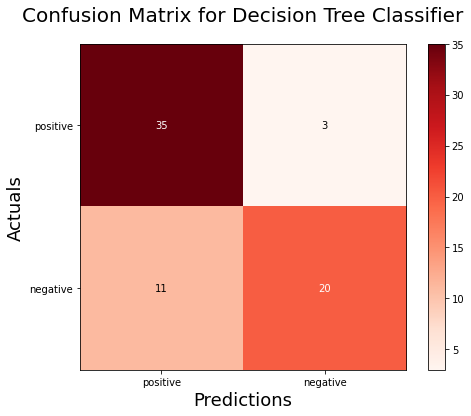

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = DecisionTreeClassifier()
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

decision_tree = DecisionTreeClassifier()

param_dict = {
    "criterion" : ['gini','entropy'],
    "max_depth" : range(1,10),
    "min_samples_split": range(1,10),
    "min_samples_leaf": range(1,5)
}

grid = GridSearchCV(decision_tree,
                    param_grid = param_dict,
                    cv = 10,
                    verbose = 1,
                    n_jobs = -1)

grid.fit(X_train_sc_PCA, y_train)
best_grid = grid.best_estimator_
y_pred = best_grid.predict(X_test_sc_PCA)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Decision Tree Classifier')

Best component parameter 10
Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'learning_rate': 0.1, 'n_estimators': 1000}
Adaboost Classifier
Accuracy: 0.7681159420289855
Macro f1-score: 0.7620689655172415




<Figure size 432x288 with 0 Axes>

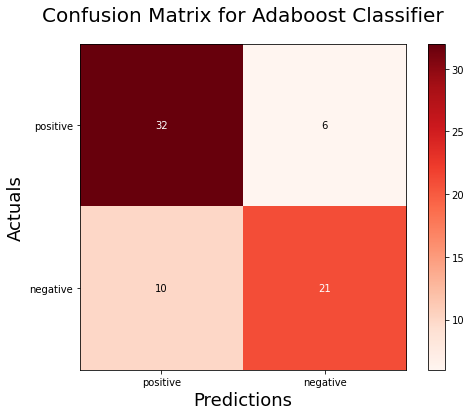

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = AdaBoostClassifier(random_state=0)
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

ada_boost = AdaBoostClassifier(random_state=0)
param_dict = {'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.05,0.1]}

grid = GridSearchCV(ada_boost,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_train_sc_PCA, y_train)
best_grid = grid.best_estimator_
y_pred = best_grid.predict(X_test_sc_PCA)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Adaboost Classifier')

Best component parameter 2
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
RandomForest Classifier
Accuracy: 0.8260869565217391
Macro f1-score: 0.8215517241379311




<Figure size 432x288 with 0 Axes>

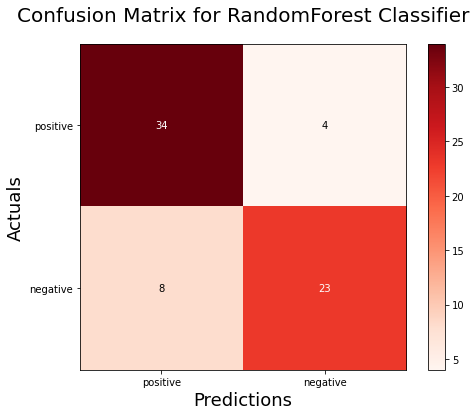

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = RandomForestClassifier(random_state = 0)
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

rfc = RandomForestClassifier(random_state=0)

param_dict = { 
    'n_estimators': [100,200,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train_sc_PCA, y_train)
best_grid = grid.best_estimator_
y_pred = best_grid.predict(X_test_sc_PCA)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'RandomForest Classifier')

Best component parameter 3
Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
KNeighbors Classifier
Accuracy: 0.7681159420289855
Macro f1-score: 0.765704584040747




<Figure size 432x288 with 0 Axes>

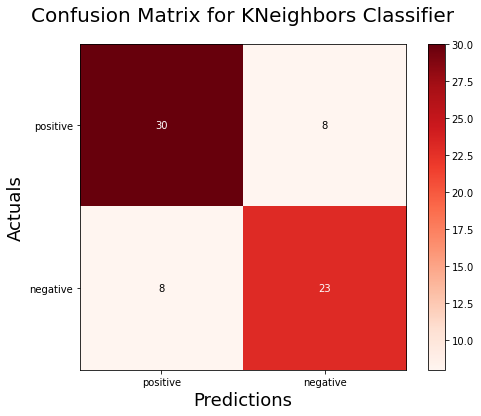

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = KNeighborsClassifier()
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

neigh = KNeighborsClassifier()

param_dict = { 
    'n_neighbors': range(2,10),
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidean','manhattan']
}

grid = GridSearchCV(neigh,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train_sc_PCA, y_train)
best_grid = grid.best_estimator_
y_pred = best_grid.predict(X_test_sc_PCA)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'KNeighbors Classifier')

Best component parameter 10
Fitting 10 folds for each of 48 candidates, totalling 480 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Support Vector Classifier
Accuracy: 0.855072463768116
Macro f1-score: 0.8525641025641026




<Figure size 432x288 with 0 Axes>

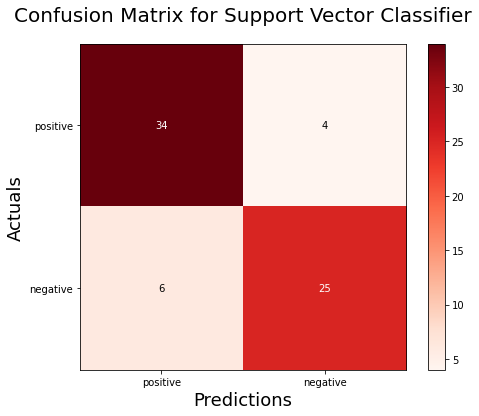

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

n_comp_list = [i for i in range(2,11)]
n_list = []
max_acc = float('-inf')
for i in n_comp_list:
  pca = PCA(n_components=i)
  X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
  X_test_sc_PCA = pca.transform(X_test_sc)
  clf = SVC()
  clf.fit(X_train_sc_PCA, y_train)
  y_pred_train = clf.predict(X_train_sc_PCA)
  acc = accuracy_score(y_train,y_pred_train)
  if acc > max_acc:
    max_acc = acc
    n_list.append(i)
print('Best component parameter',n_list[-1])

pca = PCA(n_components=n_list[-1])
X_train_sc_PCA = pca.fit_transform(X_train_sc,y_train)
X_test_sc_PCA = pca.transform(X_test_sc)

svc = SVC()

param_dict = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svc,
                    param_grid = param_dict,
                    cv=10,
                    verbose=1,
                    n_jobs=-1)


grid.fit(X_train_sc_PCA, y_train)
best_grid = grid.best_estimator_
y_pred = best_grid.predict(X_test_sc_PCA)
print(grid.best_params_)
calc_metrics(y_test,y_pred,'Support Vector Classifier')